In [421]:
# IMPORTANT! RUN THIS CELL BEFORE ANYTHING ELSE!
from typing import Callable, cast
from sklearn.exceptions import NotFittedError
from sklearn.utils.validation import check_is_fitted
from IPython.display import display
from pathlib import Path
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.metrics import root_mean_squared_error, mean_absolute_percentage_error
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer
from ydata_profiling import ProfileReport
import pandas as pd
import pandas._typing
import numpy as np

class StopExecution(Exception):
    def _render_traceback_(self):
        return []


def compare_metrics(
    metrics_1: dict[str, float],
    metrics_2: dict[str, float],
    name_1: str,
    name_2: str,
) -> pd.DataFrame:
    """
    Return a DataFrame comparing the metrics of two experiments.
    """
    return pd.DataFrame(
        [metrics_1, metrics_2],
        index=cast(pandas._typing.Axes, [name_1, name_2]),
    ).T.assign(Delta=lambda df: df[name_1] - df[name_2])

In [422]:
data_raw = pd.read_csv("data/Bacteria_dataset_Multiresictance.csv")
print(data_raw.shape)
data_raw.head()

(10710, 27)


,ID,Name,Email,Address,age/gender,Souches,Diabetes,Hypertension,Hospital_before,Infection_Freq,...,AN,Acide nalidixique,ofx,CIP,C,Co-trimoxazole,Furanes,colistine,Collection_Date,Notes
0,S290,Elizabeth Lawrence,elizabeth.lawrence@example.com,"6350 Robinson Loaf Apt. 447, Paulfurt, RI 30252",37/F,S290 Escherichia coli,No,No,No,0.0,...,S,S,S,S,R,S,S,S,5 Fev 2025,Patient had fever??
1,S291,Tina Sanders,tina.sanders@example.com,"78594 Galloway Port Suite 762, South Tanyatown...",29/F,S291 Morganella morganii,True,No,No,3.0,...,S,S,S,S,S,S,S,S,08/05/2021,تم العلاج
2,S292,Erin Cooke,erin.cooke@example.com,"76661 Isaiah Manors, North Benjamin, HI 85195",77/F,S292 Proteus mirabilis,True,No,No,3.0,...,S,S,S,R,R,S,S,S,01/05/2022,NADA
3,S293,Mrs. Sharon Watson,mrs..sharon.watson@example.com,"1670 Thompson Way Apt. 520, Andrewbury, IL 11534",NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2020-01-05,PACIENTO ENFERMO
4,S294,Erika Stewart,erika.stewart@example.com,"76838 Patrick Green Suite 538, Torresmouth, ME...",13/F,S294 Escherichia coli,No,Yes,No,1.0,...,R,S,S,S,S,S,S,S,error,NADA


In [423]:
data_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10710 entries, 0 to 10709
Data columns (total 27 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   ID                 10710 non-null  object
 1   Name               10710 non-null  object
 2   Email              10710 non-null  object
 3   Address            10710 non-null  object
 4   age/gender         10089 non-null  object
 5   Souches            10070 non-null  object
 6   Diabetes           10075 non-null  object
 7   Hypertension       10080 non-null  object
 8   Hospital_before    10073 non-null  object
 9   Infection_Freq     10071 non-null  object
 10  AMX/AMP            10052 non-null  object
 11  AMC                10078 non-null  object
 12  CZ                 10082 non-null  object
 13  FOX                10085 non-null  object
 14  CTX/CRO            10086 non-null  object
 15  IPM                10077 non-null  object
 16  GEN                10067 non-null  objec

In [424]:
# Normalizing data for NaN values

missing_tokens = ['?', 'missing', 'Missing', 'None', 'none', '', 'NaN', 'nan']
data_raw.replace(to_replace=missing_tokens, value=np.nan, inplace=True)

In [425]:
data_raw.isna().sum()

ID                      0
Name                    0
Email                   0
Address                 0
age/gender            763
Souches               763
Diabetes              763
Hypertension          763
Hospital_before       763
Infection_Freq        834
AMX/AMP               753
AMC                   753
CZ                    753
FOX                   753
CTX/CRO               753
IPM                   753
GEN                   753
AN                    753
Acide nalidixique     753
ofx                   753
CIP                   753
C                     753
Co-trimoxazole        753
Furanes               753
colistine             753
Collection_Date      1807
Notes                 244
dtype: int64

In [426]:
data_raw.columns = (
    data_raw.columns
    .str.strip()
    .str.lower()
    .str.replace(' ', '_')
)

In [427]:
data_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10710 entries, 0 to 10709
Data columns (total 27 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   id                 10710 non-null  object
 1   name               10710 non-null  object
 2   email              10710 non-null  object
 3   address            10710 non-null  object
 4   age/gender         9947 non-null   object
 5   souches            9947 non-null   object
 6   diabetes           9947 non-null   object
 7   hypertension       9947 non-null   object
 8   hospital_before    9947 non-null   object
 9   infection_freq     9876 non-null   object
 10  amx/amp            9957 non-null   object
 11  amc                9957 non-null   object
 12  cz                 9957 non-null   object
 13  fox                9957 non-null   object
 14  ctx/cro            9957 non-null   object
 15  ipm                9957 non-null   object
 16  gen                9957 non-null   objec

In [428]:
data = data_raw.drop(columns=["notes"])
PROFILE_REPORT_PATH = Path("profile.html")
if PROFILE_REPORT_PATH.exists():
    PROFILE_REPORT_PATH.unlink(missing_ok=True)
    print("Existing profile report removed")
ProfileReport(data, title="Profiling Report on Bacteria Dataset").to_file(PROFILE_REPORT_PATH)
if not PROFILE_REPORT_PATH.exists():
    raise StopExecution(
        f"The profile report was not generated at {PROFILE_REPORT_PATH}"
    )

Existing profile report removed


Export report to file: 100%|██████████| 1/1 [00:00<00:00, 97.35it/s]


In [429]:
# Split age/gender column into two separate columns
def split_age_gender(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()
    df[["age", "gender"]] = df["age/gender"].str.split("/", expand=True)
    df.drop(columns=["age/gender"], inplace=True)
    return df
data_raw = split_age_gender(data_raw)

In [430]:
data_raw.head()

,id,name,email,address,souches,diabetes,hypertension,hospital_before,infection_freq,amx/amp,...,ofx,cip,c,co-trimoxazole,furanes,colistine,collection_date,notes,age,gender
0,S290,Elizabeth Lawrence,elizabeth.lawrence@example.com,"6350 Robinson Loaf Apt. 447, Paulfurt, RI 30252",S290 Escherichia coli,No,No,No,0.0,R,...,S,S,R,S,S,S,5 Fev 2025,Patient had fever??,37,F
1,S291,Tina Sanders,tina.sanders@example.com,"78594 Galloway Port Suite 762, South Tanyatown...",S291 Morganella morganii,True,No,No,3.0,S,...,S,S,S,S,S,S,08/05/2021,تم العلاج,29,F
2,S292,Erin Cooke,erin.cooke@example.com,"76661 Isaiah Manors, North Benjamin, HI 85195",S292 Proteus mirabilis,True,No,No,3.0,S,...,S,R,R,S,S,S,01/05/2022,NADA,77,F
3,S293,Mrs. Sharon Watson,mrs..sharon.watson@example.com,"1670 Thompson Way Apt. 520, Andrewbury, IL 11534",NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,2020-01-05,PACIENTO ENFERMO,NaN,NaN
4,S294,Erika Stewart,erika.stewart@example.com,"76838 Patrick Green Suite 538, Torresmouth, ME...",S294 Escherichia coli,No,Yes,No,1.0,S,...,S,S,S,S,S,S,error,NADA,13,F


In [431]:
# Splitting Souches column
def split_id_strain(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()
    df[['strain_code', 'strain']] = df['souches'].str.split(' ', n=1, expand=True) 
    df.drop(columns=["strain_code","souches"], inplace=True)
    return df 
data_raw = split_id_strain(data_raw)

In [432]:
data_raw.head()

,id,name,email,address,diabetes,hypertension,hospital_before,infection_freq,amx/amp,amc,...,cip,c,co-trimoxazole,furanes,colistine,collection_date,notes,age,gender,strain
0,S290,Elizabeth Lawrence,elizabeth.lawrence@example.com,"6350 Robinson Loaf Apt. 447, Paulfurt, RI 30252",No,No,No,0.0,R,R,...,S,R,S,S,S,5 Fev 2025,Patient had fever??,37,F,Escherichia coli
1,S291,Tina Sanders,tina.sanders@example.com,"78594 Galloway Port Suite 762, South Tanyatown...",True,No,No,3.0,S,R,...,S,S,S,S,S,08/05/2021,تم العلاج,29,F,Morganella morganii
2,S292,Erin Cooke,erin.cooke@example.com,"76661 Isaiah Manors, North Benjamin, HI 85195",True,No,No,3.0,S,R,...,R,R,S,S,S,01/05/2022,NADA,77,F,Proteus mirabilis
3,S293,Mrs. Sharon Watson,mrs..sharon.watson@example.com,"1670 Thompson Way Apt. 520, Andrewbury, IL 11534",NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,2020-01-05,PACIENTO ENFERMO,NaN,NaN,NaN
4,S294,Erika Stewart,erika.stewart@example.com,"76838 Patrick Green Suite 538, Torresmouth, ME...",No,Yes,No,1.0,S,S,...,S,S,S,S,S,error,NADA,13,F,Escherichia coli


In [433]:
data_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10710 entries, 0 to 10709
Data columns (total 28 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   id                 10710 non-null  object
 1   name               10710 non-null  object
 2   email              10710 non-null  object
 3   address            10710 non-null  object
 4   diabetes           9947 non-null   object
 5   hypertension       9947 non-null   object
 6   hospital_before    9947 non-null   object
 7   infection_freq     9876 non-null   object
 8   amx/amp            9957 non-null   object
 9   amc                9957 non-null   object
 10  cz                 9957 non-null   object
 11  fox                9957 non-null   object
 12  ctx/cro            9957 non-null   object
 13  ipm                9957 non-null   object
 14  gen                9957 non-null   object
 15  an                 9957 non-null   object
 16  acide_nalidixique  9957 non-null   objec

In [434]:
data_raw["strain"].value_counts()

strain
Escherichia coli           4864
Enterobacteria spp.         802
Proteus mirabilis           598
Klebsiella pneumoniae       565
Citrobacter spp.            481
E.coi                       432
E.cli                       396
E. coli                     391
Morganella morganii         305
Serratia marcescens         256
Pseudomonas aeruginosa      200
Acinetobacter baumannii     181
Enter.bacteria spp.         100
Enteobacteria spp.           95
Klbsiella pneumoniae         74
Klebsie.lla pneumoniae       63
Protus mirabilis             51
Proeus mirabilis             47
Prot.eus mirabilis           46
Name: count, dtype: int64

In [435]:
data_raw["strain_clean"] = (
    data_raw["strain"]
    .str.lower()
    .str.replace(r"[^a-z\s\.]", "", regex=True)  # supprime caractères parasites
    .str.replace(r"\s+", " ", regex=True)        # espaces multiples → un espace
    .str.strip()                                 # supprime espaces en trop
)

In [436]:
data_raw["strain_clean"].value_counts()

strain_clean
escherichia coli           4864
enterobacteria spp.         802
proteus mirabilis           598
klebsiella pneumoniae       565
citrobacter spp.            481
e.coi                       432
e.cli                       396
e. coli                     391
morganella morganii         305
serratia marcescens         256
pseudomonas aeruginosa      200
acinetobacter baumannii     181
enter.bacteria spp.         100
enteobacteria spp.           95
klbsiella pneumoniae         74
klebsie.lla pneumoniae       63
protus mirabilis             51
proeus mirabilis             47
prot.eus mirabilis           46
Name: count, dtype: int64

In [437]:
data_raw["strain"].isna().sum()

np.int64(763)

In [438]:
def normalize_bacteria(name: str) -> str:

    if pd.isna(name):
        return name

    name = name.lower().strip()

    if "coli" in name or "coi" in name or "cli" in name:
        return "Escherichia coli"
    elif "enterobacter" in name or "ente" in name:
        return "Enterobacteria spp."
    elif "proteus" in name or "protus" in name or "proeus" in name or "prot" in name:
        return "Proteus mirabilis"
    elif "klebsiella" in name or "klbsiella" in name or "klebsie" in name:
        return "Klebsiella pneumoniae"
    elif "citrobacter" in name:
        return "Citrobacter spp."
    elif "morganella" in name:
        return "Morganella morganii"
    elif "serratia" in name:
        return "Serratia marcescens"
    elif "pseudomonas" in name:
        return "Pseudomonas aeruginosa"
    elif "acinetobacter" in name:
        return "Acinetobacter baumannii"
    else:
        return name.capitalize()

In [439]:
data_raw["strain_norm"] = data_raw["strain_clean"].apply(normalize_bacteria)

In [440]:
data_raw["strain_clean"].isna().sum()

np.int64(763)

In [441]:
data_raw["strain_norm"].value_counts()

strain_norm
Escherichia coli           6083
Enterobacteria spp.         997
Proteus mirabilis           742
Klebsiella pneumoniae       702
Citrobacter spp.            481
Morganella morganii         305
Serratia marcescens         256
Pseudomonas aeruginosa      200
Acinetobacter baumannii     181
Name: count, dtype: int64

In [442]:
data_raw.drop(columns=["strain", "strain_clean"], inplace=True)

In [443]:
# Remove name, email columns to respect RGPD
data_raw.drop(columns=["name", "email"], inplace=True)

In [444]:
data_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10710 entries, 0 to 10709
Data columns (total 26 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   id                 10710 non-null  object
 1   address            10710 non-null  object
 2   diabetes           9947 non-null   object
 3   hypertension       9947 non-null   object
 4   hospital_before    9947 non-null   object
 5   infection_freq     9876 non-null   object
 6   amx/amp            9957 non-null   object
 7   amc                9957 non-null   object
 8   cz                 9957 non-null   object
 9   fox                9957 non-null   object
 10  ctx/cro            9957 non-null   object
 11  ipm                9957 non-null   object
 12  gen                9957 non-null   object
 13  an                 9957 non-null   object
 14  acide_nalidixique  9957 non-null   object
 15  ofx                9957 non-null   object
 16  cip                9957 non-null   objec

In [445]:
# Pipeline for preprocessing using transformers
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split


In [446]:
def norm_ast(v):
    if pd.isna(v): 
        return np.nan
    s = str(v).strip().upper()
    if s=='' or s in {'NA','N/A','?','MISSING'}: 
        return np.nan
    if s.startswith('R'): 
        return 'R'
    if s.startswith('S'): 
        return 'S'
    if s.startswith('I') or 'INTER' in s: 
        return 'I'
    return np.nan

In [447]:
ab_cols = [
    'amx/amp', 'amc', 'cz', 'fox', 'ctx/cro', 'ipm', 'gen',
    'an', 'acide_nalidixique', 'ofx', 'cip', 'c',
    'co-trimoxazole', 'furanes', 'colistine'
]
print("auto-detected antibiotic cols:", ab_cols)


print("--- Unique Values per Column ---")
print("-" * 35)

# --- 3. Iterate and print unique values ---
for column in ab_cols:
    # Use .unique() to get all unique values, including NaN/None
    unique_values = data_raw[column].unique()
    
    # Print the column name and the resulting unique array
    # .tolist() converts the numpy array (output of .unique()) to a standard Python list for cleaner printing
    print(f"Column: {column}")
    print(f"  Unique Values: {unique_values.tolist()}")
    print("-" * 35)

auto-detected antibiotic cols: ['amx/amp', 'amc', 'cz', 'fox', 'ctx/cro', 'ipm', 'gen', 'an', 'acide_nalidixique', 'ofx', 'cip', 'c', 'co-trimoxazole', 'furanes', 'colistine']
--- Unique Values per Column ---
-----------------------------------
Column: amx/amp
  Unique Values: ['R', 'S', nan, 's', 'i', 'r', 'Intermediate']
-----------------------------------
Column: amc
  Unique Values: ['R', nan, 'S', 's', 'r', 'Intermediate', 'i']
-----------------------------------
Column: cz
  Unique Values: ['R', 'S', nan, 'r', 'Intermediate', 'i', 's']
-----------------------------------
Column: fox
  Unique Values: ['R', nan, 'S', 's', 'i', 'Intermediate', 'r']
-----------------------------------
Column: ctx/cro
  Unique Values: ['R', 'S', nan, 'r', 'i', 's', 'Intermediate']
-----------------------------------
Column: ipm
  Unique Values: ['R', 'S', nan, 'i', 'Intermediate', 's', 'r']
-----------------------------------
Column: gen
  Unique Values: ['S', nan, 'R', 'i', 's', 'r', 'Intermediate']


In [448]:
for c in ab_cols:
    data_raw[c+"_norm"] = data_raw[c].apply(norm_ast)
    data_raw.drop(columns=[c], inplace=True)

In [449]:
data_raw.head()

,id,address,diabetes,hypertension,hospital_before,infection_freq,collection_date,notes,age,gender,...,ipm_norm,gen_norm,an_norm,acide_nalidixique_norm,ofx_norm,cip_norm,c_norm,co-trimoxazole_norm,furanes_norm,colistine_norm
0,S290,"6350 Robinson Loaf Apt. 447, Paulfurt, RI 30252",No,No,No,0.0,5 Fev 2025,Patient had fever??,37,F,...,R,S,S,S,S,S,R,S,S,S
1,S291,"78594 Galloway Port Suite 762, South Tanyatown...",True,No,No,3.0,08/05/2021,تم العلاج,29,F,...,R,S,S,S,S,S,S,S,S,S
2,S292,"76661 Isaiah Manors, North Benjamin, HI 85195",True,No,No,3.0,01/05/2022,NADA,77,F,...,S,S,S,S,S,R,R,S,S,S
3,S293,"1670 Thompson Way Apt. 520, Andrewbury, IL 11534",NaN,NaN,NaN,NaN,2020-01-05,PACIENTO ENFERMO,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,S294,"76838 Patrick Green Suite 538, Torresmouth, ME...",No,Yes,No,1.0,error,NADA,13,F,...,R,R,R,S,S,S,S,S,S,S


In [450]:
import seaborn as sns

In [451]:
# Checking for Duplicated values
duplicate_rows = data_raw[data_raw.duplicated()]
print(duplicate_rows)

Empty DataFrame
Columns: [id, address, diabetes, hypertension, hospital_before, infection_freq, collection_date, notes, age, gender, strain_norm, amx/amp_norm, amc_norm, cz_norm, fox_norm, ctx/cro_norm, ipm_norm, gen_norm, an_norm, acide_nalidixique_norm, ofx_norm, cip_norm, c_norm, co-trimoxazole_norm, furanes_norm, colistine_norm]
Index: []

[0 rows x 26 columns]


In [452]:
# Unique values 
print(f"unique values of column diabetes : {data_raw['diabetes'].unique()}")
print(f"unique values of column hypertension : {data_raw['hypertension'].unique()}")
print(f"unique values of column hospital_before : {data_raw['hospital_before'].unique()}")

unique values of column diabetes : ['No' 'True' nan]
unique values of column hypertension : ['No' nan 'Yes']
unique values of column hospital_before : ['No' nan 'Yes']


In [453]:
# Normalizing Unique values
bool_map = {'No': False, 'Yes': True, 'True': True}

bool_cols = ['diabetes', 'hypertension', 'hospital_before']

for col in bool_cols:
    data_raw[col] = data_raw[col].map(bool_map).astype('boolean')
    data_raw[col] = data_raw[col].fillna(data_raw[col].mode()[0])

In [454]:
data_raw.isna().sum()

id                           0
address                      0
diabetes                     0
hypertension                 0
hospital_before              0
infection_freq             834
collection_date           1807
notes                      244
age                        763
gender                     763
strain_norm                763
amx/amp_norm               753
amc_norm                   753
cz_norm                    753
fox_norm                   753
ctx/cro_norm               753
ipm_norm                   753
gen_norm                   753
an_norm                    753
acide_nalidixique_norm     753
ofx_norm                   753
cip_norm                   753
c_norm                     753
co-trimoxazole_norm        753
furanes_norm               753
colistine_norm             753
dtype: int64

In [455]:
data_raw["collection_date"].value_counts()

collection_date
2024-12-31    1461
2020-01-05    1337
08/05/2021     719
5 Fev 2025     712
05/01/2025     708
05/03/2022     696
2023-12-31     693
2020-12-31     693
01/05/2022     692
3 Jan 1019     684
error          508
Name: count, dtype: int64

In [456]:
# Replace month abbreviations 
month_map = {
    'Fev': 'Feb', 
}

for k, v in month_map.items():
    data_raw['collection_date'] = data_raw['collection_date'].str.replace(k, v, regex=False)

# Create a function to parse different formats
def parse_date(val):
    for fmt in ("%d-%m-%Y", "%d/%m/%Y", "%Y-%m-%d", "%d %b %Y"):
        try:
            return pd.to_datetime(val, format=fmt, dayfirst=True)
        except:
            continue
    return pd.NaT

# Apply parsing function
data_raw['collection_date'] = data_raw['collection_date'].apply(lambda x: parse_date(str(x)))

# Format as dd-mm-yyyy string
data_raw['collection_date'] = data_raw['collection_date'].dt.strftime('%d-%m-%Y')

In [457]:
data_raw['collection_date'].isna().sum()

np.int64(2999)

<Axes: >

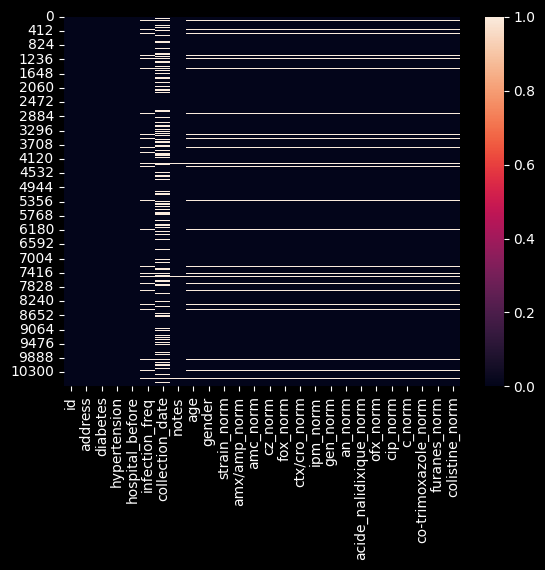

In [458]:
sns.heatmap(data_raw.isna())

In [459]:
# Droping row with all Nan values
# Count rows before dropping
before = len(data_raw)

# Drop rows where all columns EXCEPT ['id', 'address','collection_date','notes'] are NaN
data_raw.dropna(
    axis=0,
    how='all',
    subset=[col for col in data_raw.columns if col not in ['id', "address", "collection_date", "notes"]],
    inplace=True
)

# Reset the index
data_raw.reset_index(drop=True, inplace=True)

# Count rows after dropping and show how many were removed
after = len(data_raw)
print(f"Rows dropped: {before - after}")

Rows dropped: 0


In [460]:
data_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10710 entries, 0 to 10709
Data columns (total 26 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   id                      10710 non-null  object 
 1   address                 10710 non-null  object 
 2   diabetes                10710 non-null  boolean
 3   hypertension            10710 non-null  boolean
 4   hospital_before         10710 non-null  boolean
 5   infection_freq          9876 non-null   object 
 6   collection_date         7711 non-null   object 
 7   notes                   10466 non-null  object 
 8   age                     9947 non-null   object 
 9   gender                  9947 non-null   object 
 10  strain_norm             9947 non-null   object 
 11  amx/amp_norm            9957 non-null   object 
 12  amc_norm                9957 non-null   object 
 13  cz_norm                 9957 non-null   object 
 14  fox_norm                9957 non-null 

In [461]:
# Numeric columns
num_cols = ['infection_freq', 'age']
data_raw[num_cols] = data_raw[num_cols].apply(pd.to_numeric, errors='coerce')
# Iterative Imputation on Numarical columns
from sklearn.experimental import enable_iterative_imputer  
from sklearn.impute import IterativeImputer
iter_imputer = IterativeImputer(max_iter=10, random_state=0)
data_raw[num_cols] = iter_imputer.fit_transform(data_raw[num_cols])

In [462]:
data_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10710 entries, 0 to 10709
Data columns (total 26 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   id                      10710 non-null  object 
 1   address                 10710 non-null  object 
 2   diabetes                10710 non-null  boolean
 3   hypertension            10710 non-null  boolean
 4   hospital_before         10710 non-null  boolean
 5   infection_freq          10710 non-null  float64
 6   collection_date         7711 non-null   object 
 7   notes                   10466 non-null  object 
 8   age                     10710 non-null  float64
 9   gender                  9947 non-null   object 
 10  strain_norm             9947 non-null   object 
 11  amx/amp_norm            9957 non-null   object 
 12  amc_norm                9957 non-null   object 
 13  cz_norm                 9957 non-null   object 
 14  fox_norm                9957 non-null 

In [463]:
# Categorical columns
cat_cols = [
    "gender",'amx/amp_norm', 'amc_norm', 'cz_norm', 'fox_norm', 'ctx/cro_norm', 'ipm_norm', 'gen_norm',
    'an_norm', 'acide_nalidixique_norm', 'ofx_norm', 'cip_norm', 'c_norm',
    'co-trimoxazole_norm', 'furanes_norm', 'colistine_norm'
]
data_raw[cat_cols] = data_raw[cat_cols].astype('category')
for col in cat_cols:
    if data_raw[col].isna().any():
        data_raw[col] = data_raw[col].fillna(data_raw[col].mode()[0])


In [464]:
data_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10710 entries, 0 to 10709
Data columns (total 26 columns):
 #   Column                  Non-Null Count  Dtype   
---  ------                  --------------  -----   
 0   id                      10710 non-null  object  
 1   address                 10710 non-null  object  
 2   diabetes                10710 non-null  boolean 
 3   hypertension            10710 non-null  boolean 
 4   hospital_before         10710 non-null  boolean 
 5   infection_freq          10710 non-null  float64 
 6   collection_date         7711 non-null   object  
 7   notes                   10466 non-null  object  
 8   age                     10710 non-null  float64 
 9   gender                  10710 non-null  category
 10  strain_norm             9947 non-null   object  
 11  amx/amp_norm            10710 non-null  category
 12  amc_norm                10710 non-null  category
 13  cz_norm                 10710 non-null  category
 14  fox_norm              

In [465]:
# Droping columns
# data_raw.drop(columns=['id', 'name', 'email', 'address', 'notes','collection_date'], inplace=True)
# data_raw.reset_index(drop=True, inplace=True)

<Axes: >

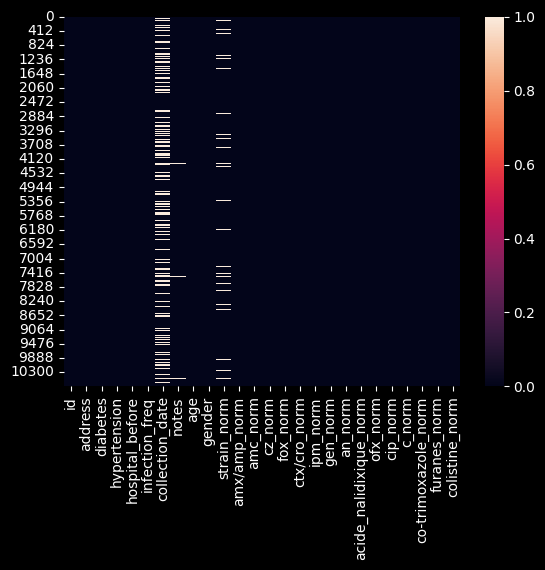

In [466]:
sns.heatmap(data_raw.isna())